# `TauModel` Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the basic features of the `TauModel` model. `TauModel` models the 1612, 1665, 1667, and 1720 MHz hyperfine transitions of OH and predicts their optical depth spectra.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

from amoeba2 import TauModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.3+2.gfe5a862.dirty
amoeba2 version: 1.0.1+2.gd6df2a6.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `TauModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"tau_1612", "tau_1665", "tau_1667", and "tau_1720"`.

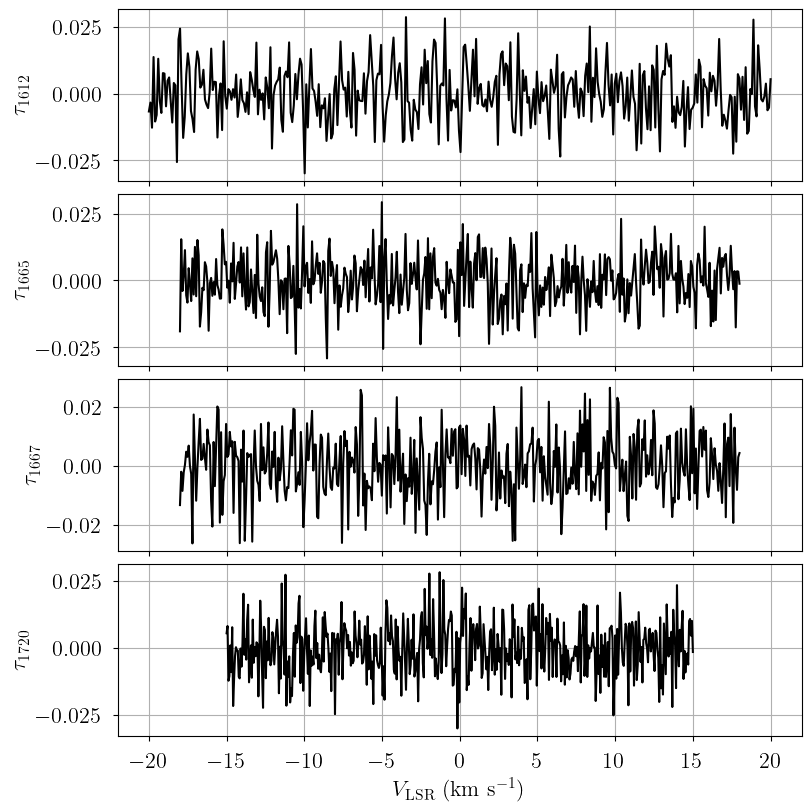

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_tau = {
    "1612": 0.01,
    "1665": 0.01,
    "1667": 0.01,
    "1720": 0.01,
}

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
tau = {label: rms_tau[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

# TauModel expects four observations
dummy_data = {
    f"tau_{label}": SpecData(
        velo_axis[label],
        tau[label],
        rms_tau[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )
    for label in velo_axis.keys()
}

# Plot dummy data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, dummy_datum in zip(axes, dummy_data.values()):
    ax.plot(dummy_datum.spectral, dummy_datum.brightness, "k-")
    ax.set_ylabel(dummy_datum.ylabel)
_ = axes[-1].set_xlabel(dummy_datum.xlabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = TauModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of optical depth rms prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
# excitation temperature for 1612, 1665, and 1667 MHz
inv_Tex_free = np.array([
    [0.2, -0.2, 0.06], # cloud 0
    [0.06, 0.1, 0.2], # cloud 1
    [0.06, 0.06, 0.1] # cloud 2
])

sim_params = {
    "log10_N_0": np.array([14.0, 14.5, 13.5]),
    "inv_Tex_free": inv_Tex_free,
    "fwhm": np.array([1.2, 1.5, 0.8]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
    "rms_tau": np.array([0.01, 0.008, 0.012, 0.01]),
}

data = {}
for i, label in enumerate(velo_axis.keys()):
    sim_params_label = sim_params.copy()
    sim_params_label[f"baseline_tau_{label}_norm"] = np.array([0.0, -1.0, 2.0])
    tau = model.model[f"tau_{label}"].eval(sim_params_label)
    data[f"tau_{label}"] = SpecData(
        velo_axis[label],
        tau,
        sim_params["rms_tau"][i],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )

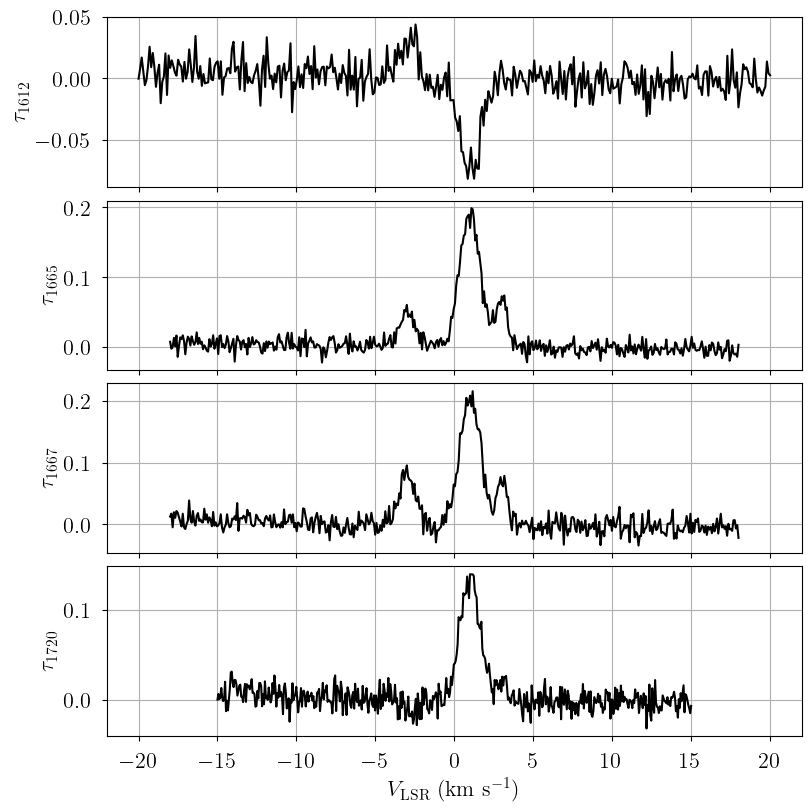

In [5]:
# Plot data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `TauModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = TauModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 1.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of optical depth rms prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

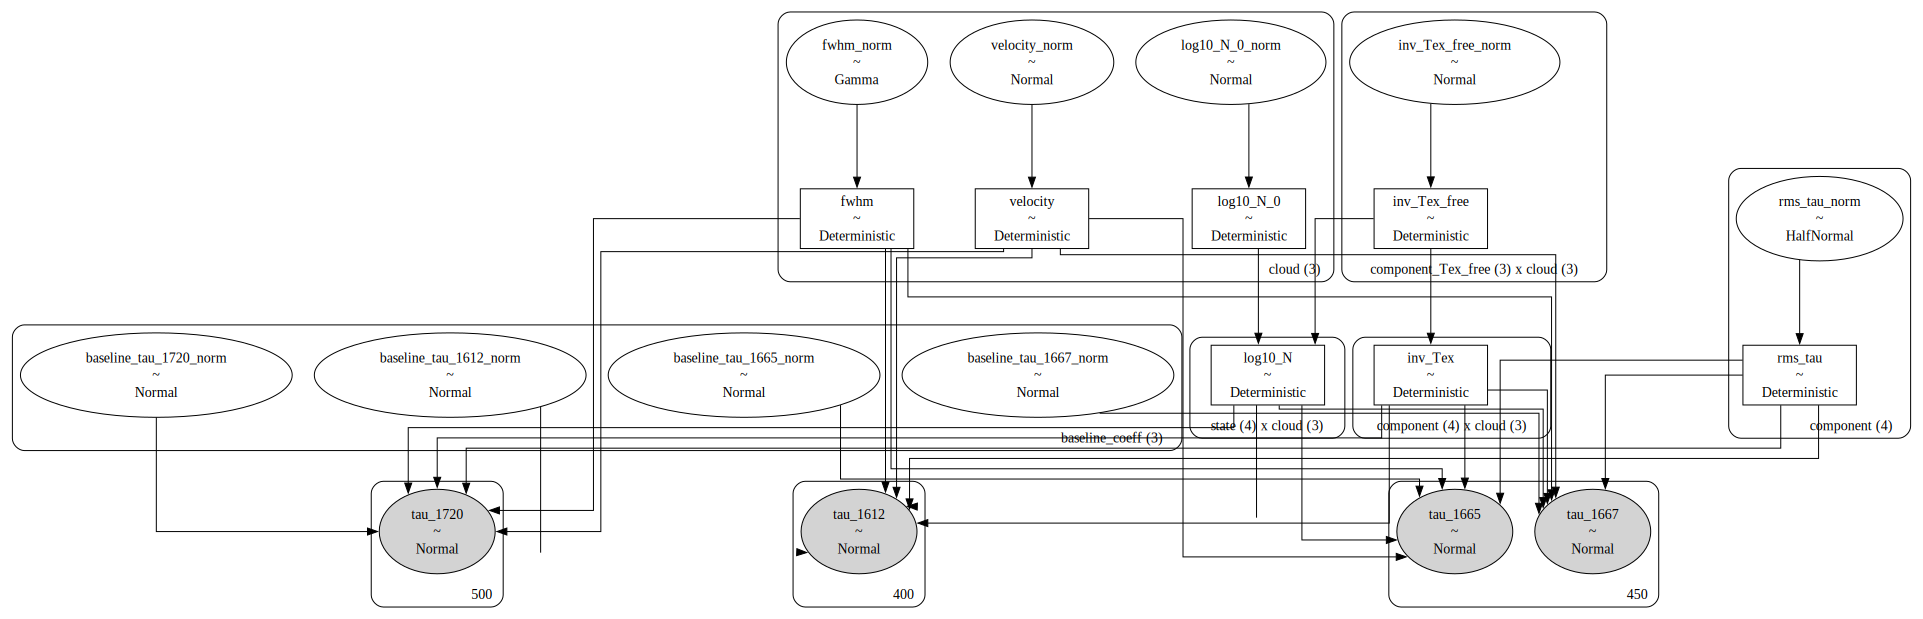

In [7]:
# Plot model graph
gviz = pm.model_to_graphviz(model.model)
gviz.graph_attr["rankdir"] = "TB"
gviz.graph_attr["splines"] = "ortho"
# gviz.graph_attr["newrank"] = "true"
gviz.graph_attr["rank"] = "same"
gviz.graph_attr["ranksep"] = "1.0"
gviz.graph_attr["nodesep"] = "0.3"
gviz.render('tau_model', format='png')
gviz

In [8]:
# model string representation
print(model.model.str_repr())

baseline_tau_1612_norm ~ Normal(0, <constant>)
baseline_tau_1665_norm ~ Normal(0, <constant>)
baseline_tau_1667_norm ~ Normal(0, <constant>)
baseline_tau_1720_norm ~ Normal(0, <constant>)
        log10_N_0_norm ~ Normal(0, 1)
     inv_Tex_free_norm ~ Normal(0, 1)
             fwhm_norm ~ Gamma(2, f())
         velocity_norm ~ Normal(0, 1)
          rms_tau_norm ~ HalfNormal(0, 1)
             log10_N_0 ~ Deterministic(f(log10_N_0_norm))
          inv_Tex_free ~ Deterministic(f(inv_Tex_free_norm))
               inv_Tex ~ Deterministic(f(inv_Tex_free_norm))
               log10_N ~ Deterministic(f(log10_N_0_norm, inv_Tex_free_norm))
                  fwhm ~ Deterministic(f(fwhm_norm))
              velocity ~ Deterministic(f(velocity_norm))
               rms_tau ~ Deterministic(f(rms_tau_norm))
              tau_1612 ~ Normal(f(baseline_tau_1612_norm, log10_N_0_norm, fwhm_norm, velocity_norm, inv_Tex_free_norm), f(rms_tau_norm))
              tau_1665 ~ Normal(f(baseline_tau_1665_norm,

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, fwhm_norm, inv_Tex_free_norm, log10_N_0_norm, rms_tau_norm, tau_1612, tau_1665, tau_1667, tau_1720, velocity_norm]


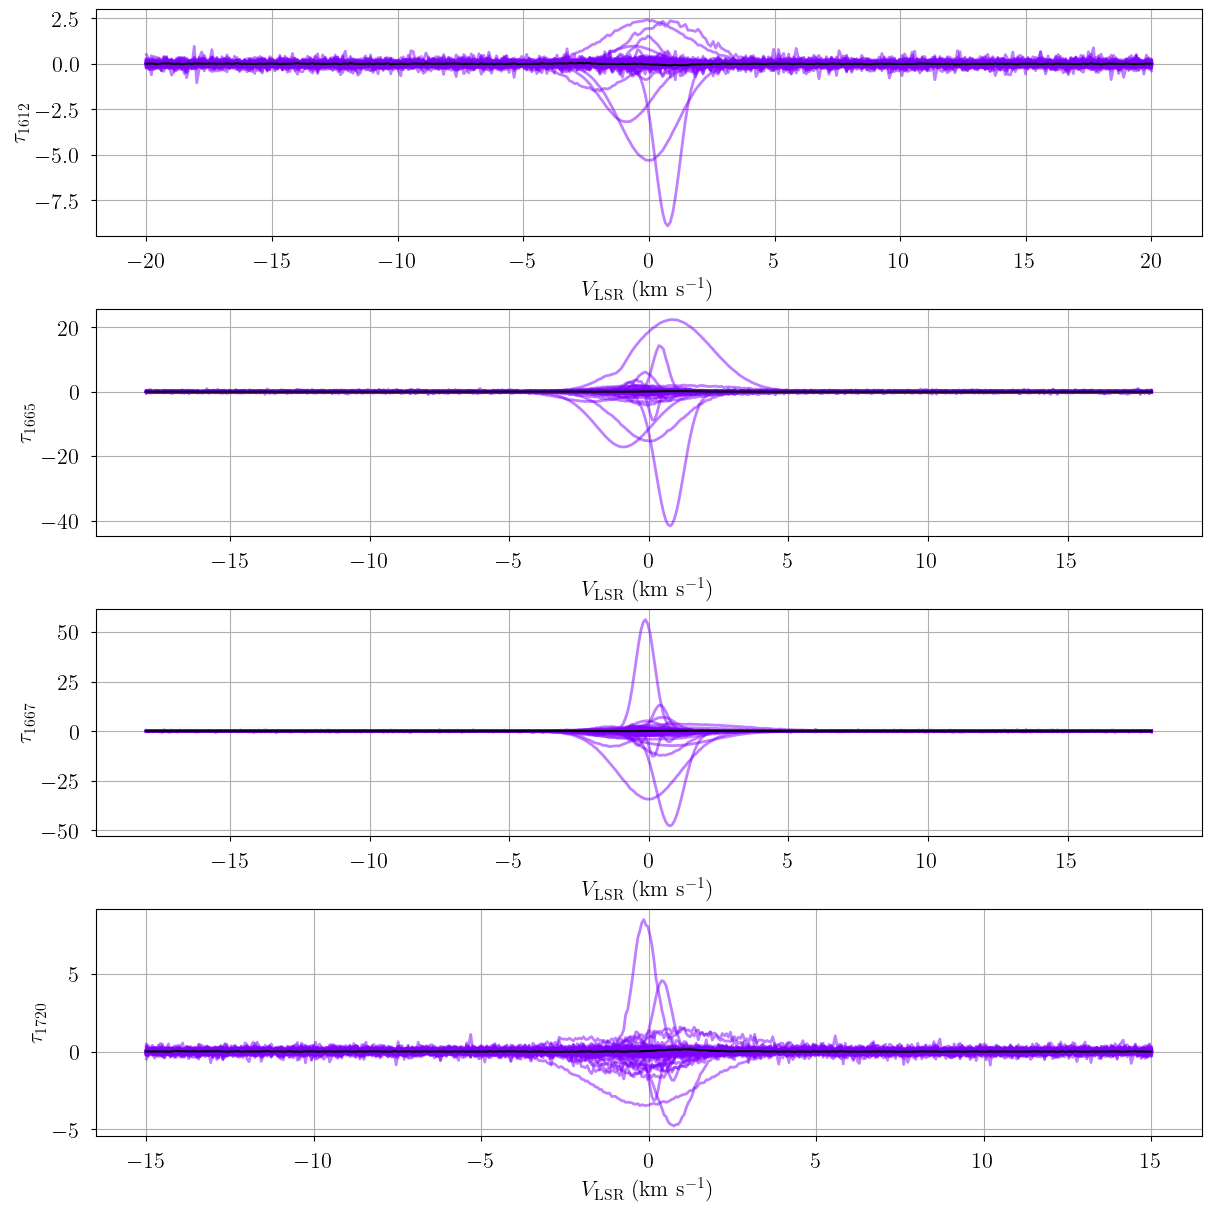

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
axes = plot_predictive(model.data, prior.prior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6400
Interrupted at 6,399 [6%]: Average Loss = -4,801.8


Runtime: 0.94 minutes


In [11]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_tau_1612_norm[0]    0.084  0.032   0.025    0.140      0.001   
baseline_tau_1612_norm[1]   -0.633  0.116  -0.844   -0.422      0.004   
baseline_tau_1612_norm[2]    0.956  0.583  -0.034    2.123      0.020   
baseline_tau_1665_norm[0]   -0.353  0.012  -0.374   -0.329      0.000   
baseline_tau_1665_norm[1]   -0.278  0.043  -0.356   -0.195      0.001   
baseline_tau_1665_norm[2]    0.000  0.232  -0.455    0.424      0.008   
baseline_tau_1667_norm[0]   -0.391  0.014  -0.417   -0.364      0.000   
baseline_tau_1667_norm[1]   -0.341  0.053  -0.440   -0.248      0.002   
baseline_tau_1667_norm[2]    1.045  0.288   0.423    1.524      0.011   
baseline_tau_1720_norm[0]   -0.316  0.019  -0.353   -0.282      0.001   
baseline_tau_1720_norm[1]   -0.395  0.061  -0.507   -0.284      0.002   
baseline_tau_1720_norm[2]    1.331  0.330   0.780    1.960      0.011   
fwhm[0]                      1.193  0.044   1.115    1.280      0.002   
fwhm[1]                      0.788  0.035   0.724    0.854      0.001   
fwhm[2]                      1.529  0.016   1.499    1.557      0.000   
fwhm_norm[0]                 1.193  0.044   1.115    1.280      0.002   
fwhm_norm[1]                 0.788  0.035   0.724    0.854      0.001   
fwhm_norm[2]                 1.529  0.016   1.499    1.557      0.000   
inv_Tex[1612, 0]             2.869  0.189   2.523    3.240      0.006   
inv_Tex[1612, 1]             0.113  0.275  -0.386    0.625      0.009   
inv_Tex[1612, 2]            -2.787  0.078  -2.927   -2.639      0.002   
inv_Tex[1665, 0]             0.899  0.052   0.799    0.991      0.002   
inv_Tex[1665, 1]             1.367  0.065   1.234    1.474      0.002   
inv_Tex[1665, 2]             1.192  0.015   1.163    1.221      0.001   
inv_Tex[1667, 0]             0.755  0.039   0.679    0.825      0.001   
inv_Tex[1667, 1]             0.846  0.056   0.739    0.947      0.002   
inv_Tex[1667, 2]             0.990  0.016   0.959    1.020      0.001   
inv_Tex[1720, 0]            -1.086  0.188  -1.481   -0.761      0.006   
inv_Tex[1720, 1]             2.037  0.269   1.571    2.542      0.009   
inv_Tex[1720, 2]             4.726  0.076   4.593    4.871      0.003   
inv_Tex_free[1612, 0]        2.869  0.189   2.523    3.240      0.006   
inv_Tex_free[1612, 1]        0.113  0.275  -0.386    0.625      0.009   
inv_Tex_free[1612, 2]       -2.787  0.078  -2.927   -2.639      0.002   
inv_Tex_free[1665, 0]        0.899  0.052   0.799    0.991      0.002   
inv_Tex_free[1665, 1]        1.367  0.065   1.234    1.474      0.002   
inv_Tex_free[1665, 2]        1.192  0.015   1.163    1.221      0.001   
inv_Tex_free[1667, 0]        0.755  0.039   0.679    0.825      0.001   
inv_Tex_free[1667, 1]        0.846  0.056   0.739    0.947      0.002   
inv_Tex_free[1667, 2]        0.990  0.016   0.959    1.020      0.001   
inv_Tex_free_norm[1612, 0]   2.869  0.189   2.523    3.240      0.006   
inv_Tex_free_norm[1612, 1]   0.113  0.275  -0.386    0.625      0.009   
inv_Tex_free_norm[1612, 2]  -2.787  0.078  -2.927   -2.639      0.002   
inv_Tex_free_norm[1665, 0]   0.899  0.052   0.799    0.991      0.002   
inv_Tex_free_norm[1665, 1]   1.367  0.065   1.234    1.474      0.002   
inv_Tex_free_norm[1665, 2]   1.192  0.015   1.163    1.221      0.001   
inv_Tex_free_norm[1667, 0]   0.755  0.039   0.679    0.825      0.001   
inv_Tex_free_norm[1667, 1]   0.846  0.056   0.739    0.947      0.002   
inv_Tex_free_norm[1667, 2]   0.990  0.016   0.959    1.020      0.001   
log10_N[0, 0]               12.849  0.015  12.821   12.876      0.000   
log10_N[0, 1]               12.658  0.016  12.628   12.687      0.001   
log10_N[0, 2]               13.440  0.004  13.432   13.447      0.000   
log10_N[1, 0]               13.136  0.017  13.106   13.167      0.001   
log10_N[1, 1]               12.836  0.019  12.799   12.870      0.001   
log10_N[1, 2]               13.527  0.005  13.518   13.536      0.000   
log10_N[2, 0]  

Sampling: [tau_1612, tau_1665, tau_1667, tau_1720]


Output()

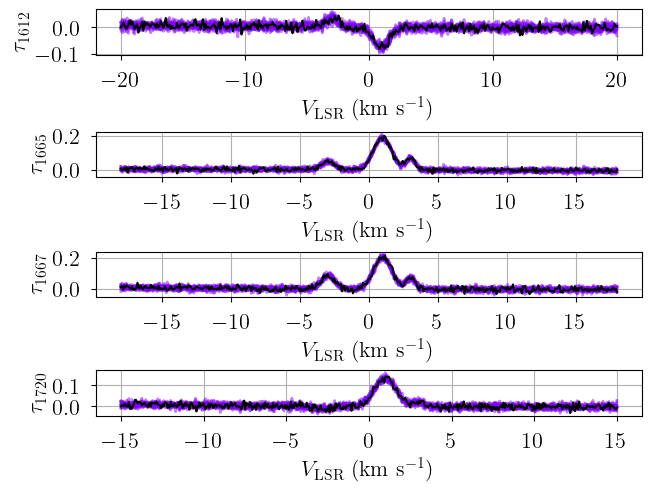

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC. Due to the strong degeneracy between column density and excitation temperature in this optical depth-only model, we may have to increase the number of tuning samples (`tune`) and the NUTS acceptance rate `target_accept` for efficient sampling.

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6400
Interrupted at 6,399 [6%]: Average Loss = -4,801.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, log10_N_0_norm, inv_Tex_free_norm, fwhm_norm, velocity_norm, rms_tau_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 741 seconds.


There were 505 divergences in converged chains.
Runtime: 14.08 minutes


In [14]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [15]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_tau_1612_norm[0]    0.076  0.039  -0.002    0.145      0.001   
baseline_tau_1612_norm[1]   -0.619  0.096  -0.804   -0.438      0.002   
baseline_tau_1612_norm[2]    0.996  0.634  -0.085    2.275      0.030   
baseline_tau_1665_norm[0]   -0.341  0.018  -0.376   -0.305      0.000   
baseline_tau_1665_norm[1]   -0.287  0.038  -0.353   -0.216      0.004   
baseline_tau_1665_norm[2]    0.060  0.331  -0.618    0.640      0.007   
baseline_tau_1667_norm[0]   -0.397  0.023  -0.440   -0.353      0.001   
baseline_tau_1667_norm[1]   -0.328  0.044  -0.412   -0.245      0.001   
baseline_tau_1667_norm[2]    1.113  0.414   0.298    1.849      0.044   
baseline_tau_1720_norm[0]   -0.319  0.025  -0.364   -0.269      0.001   
baseline_tau_1720_norm[1]   -0.406  0.058  -0.508   -0.297      0.009   
baseline_tau_1720_norm[2]    1.294  0.447   0.520    2.237      0.011   
fwhm[0]                      1.204  0.051   1.102    1.295      0.001   
fwhm[1]                      0.782  0.043   0.710    0.857      0.008   
fwhm[2]                      1.533  0.019   1.497    1.564      0.003   
fwhm_norm[0]                 1.204  0.051   1.102    1.295      0.001   
fwhm_norm[1]                 0.782  0.043   0.710    0.857      0.008   
fwhm_norm[2]                 1.533  0.019   1.497    1.564      0.003   
inv_Tex[1612, 0]             1.602  0.630   0.431    2.626      0.081   
inv_Tex[1612, 1]             0.142  0.279  -0.380    0.728      0.006   
inv_Tex[1612, 2]            -1.447  0.584  -2.471   -0.544      0.100   
inv_Tex[1665, 0]             0.493  0.203   0.126    0.830      0.029   
inv_Tex[1665, 1]             1.298  0.512   0.356    2.277      0.019   
inv_Tex[1665, 2]             0.654  0.242   0.272    1.074      0.043   
inv_Tex[1667, 0]             0.439  0.170   0.121    0.705      0.025   
inv_Tex[1667, 1]             0.824  0.357   0.192    1.489      0.013   
inv_Tex[1667, 2]             0.479  0.210   0.164    0.845      0.034   
inv_Tex[1720, 0]            -0.598  0.249  -1.031   -0.157      0.022   
inv_Tex[1720, 1]             1.922  0.851   0.423    3.479      0.032   
inv_Tex[1720, 2]             2.453  0.984   0.951    4.202      0.169   
inv_Tex_free[1612, 0]        1.602  0.630   0.431    2.626      0.081   
inv_Tex_free[1612, 1]        0.142  0.279  -0.380    0.728      0.006   
inv_Tex_free[1612, 2]       -1.447  0.584  -2.471   -0.544      0.100   
inv_Tex_free[1665, 0]        0.493  0.203   0.126    0.830      0.029   
inv_Tex_free[1665, 1]        1.298  0.512   0.356    2.277      0.019   
inv_Tex_free[1665, 2]        0.654  0.242   0.272    1.074      0.043   
inv_Tex_free[1667, 0]        0.439  0.170   0.121    0.705      0.025   
inv_Tex_free[1667, 1]        0.824  0.357   0.192    1.489      0.013   
inv_Tex_free[1667, 2]        0.479  0.210   0.164    0.845      0.034   
inv_Tex_free_norm[1612, 0]   1.602  0.630   0.431    2.626      0.081   
inv_Tex_free_norm[1612, 1]   0.142  0.279  -0.380    0.728      0.006   
inv_Tex_free_norm[1612, 2]  -1.447  0.584  -2.471   -0.544      0.100   
inv_Tex_free_norm[1665, 0]   0.493  0.203   0.126    0.830      0.029   
inv_Tex_free_norm[1665, 1]   1.298  0.512   0.356    2.277      0.019   
inv_Tex_free_norm[1665, 2]   0.654  0.242   0.272    1.074      0.043   
inv_Tex_free_norm[1667, 0]   0.439  0.170   0.121    0.705      0.025   
inv_Tex_free_norm[1667, 1]   0.824  0.357   0.192    1.489      0.013   
inv_Tex_free_norm[1667, 2]   0.479  0.210   0.164    0.845      0.034   
log10_N[0, 0]               13.146  0.205  12.827   13.539      0.026   
log10_N[0, 1]               12.720  0.184  12.395   13.070      0.007   
log10_N[0, 2]               13.724  0.166  13.468   14.020      0.037   
log10_N[1, 0]               13.405  0.192  13.106   13.767      0.024   
log10_N[1, 1]               12.902  0.200  12.524   13.276      0.007   
log10_N[1, 2]               13.874  0.193  13.564   14.210      0.042   
log10_N[2, 0]  

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [tau_1612, tau_1665, tau_1667, tau_1720]


Output()

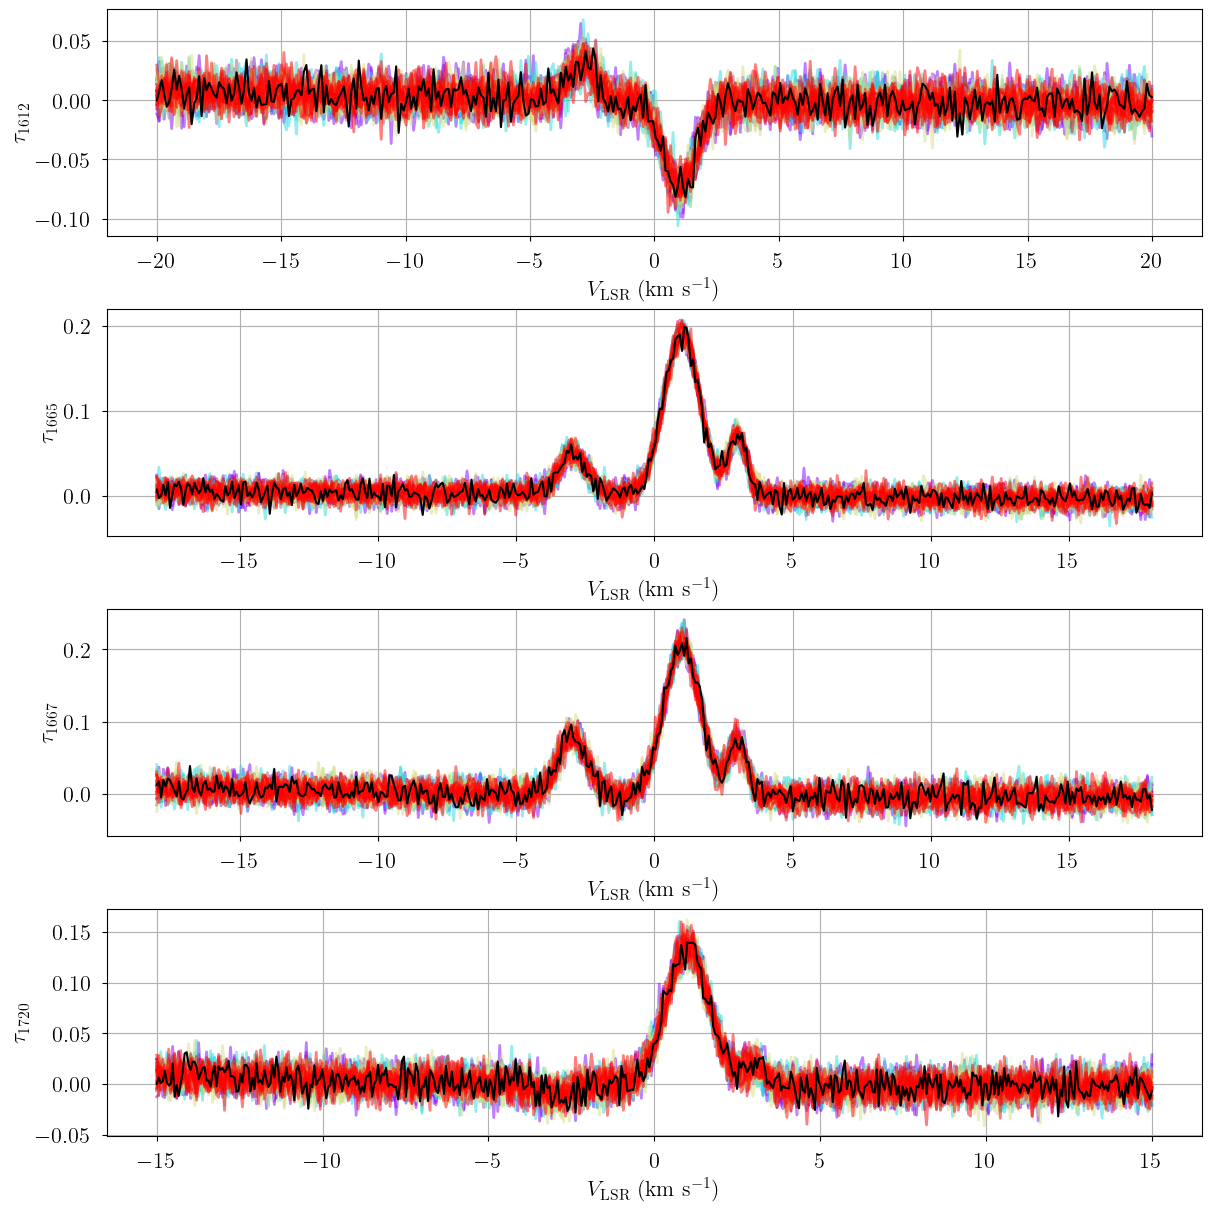

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

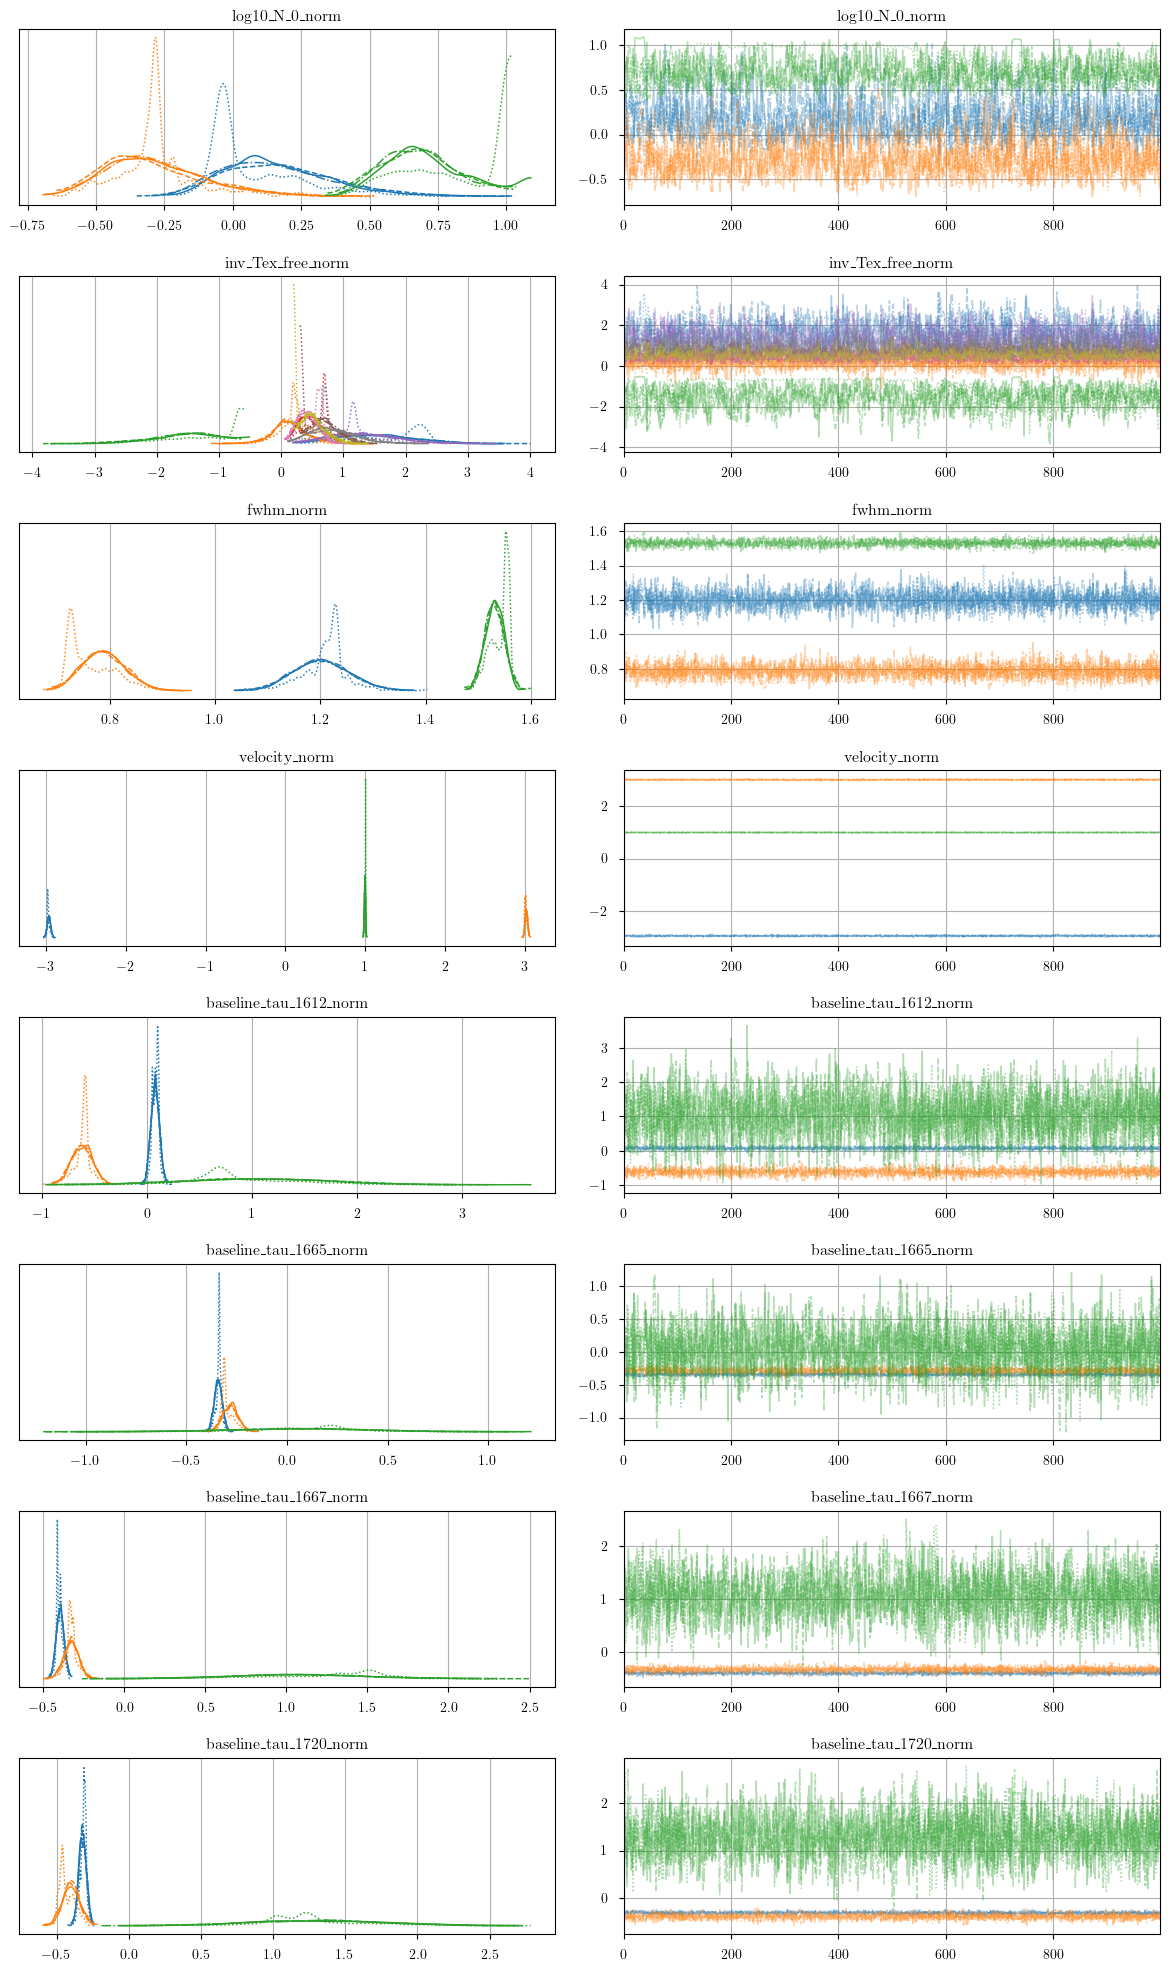

In [17]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
axes.ravel()[0].figure.set_size_inches(12, 20)
axes.ravel()[0].figure.tight_layout()

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

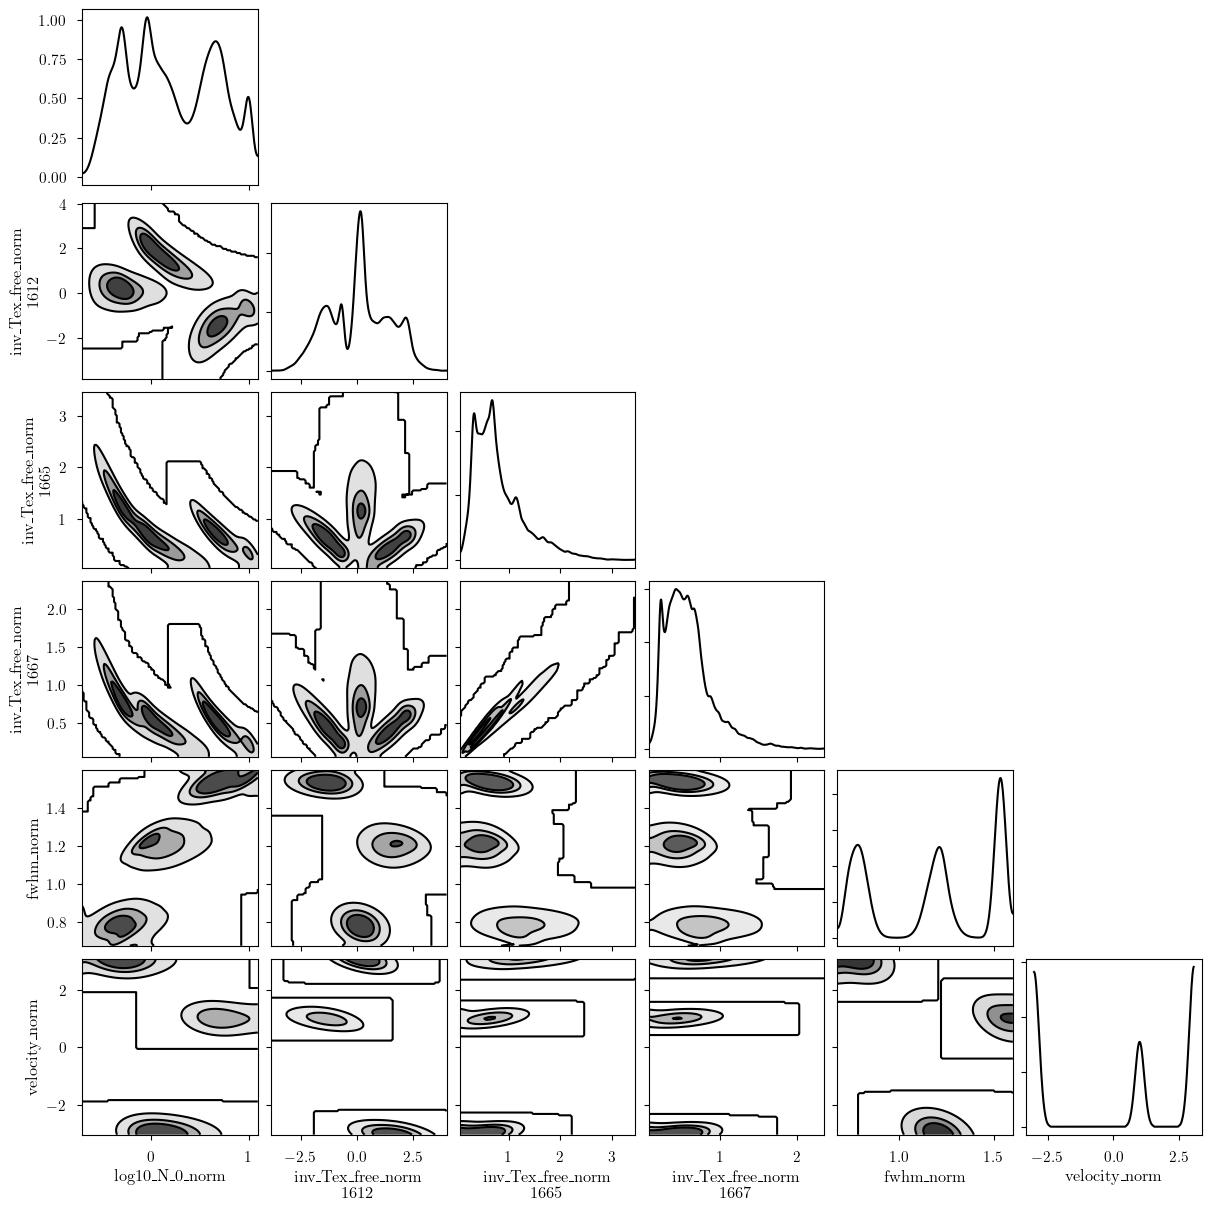

In [18]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(12, 12)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud. Also notice the tight correlation between column density and excitation temperature: optical depth spectra alone struggle to break this degeneracy!

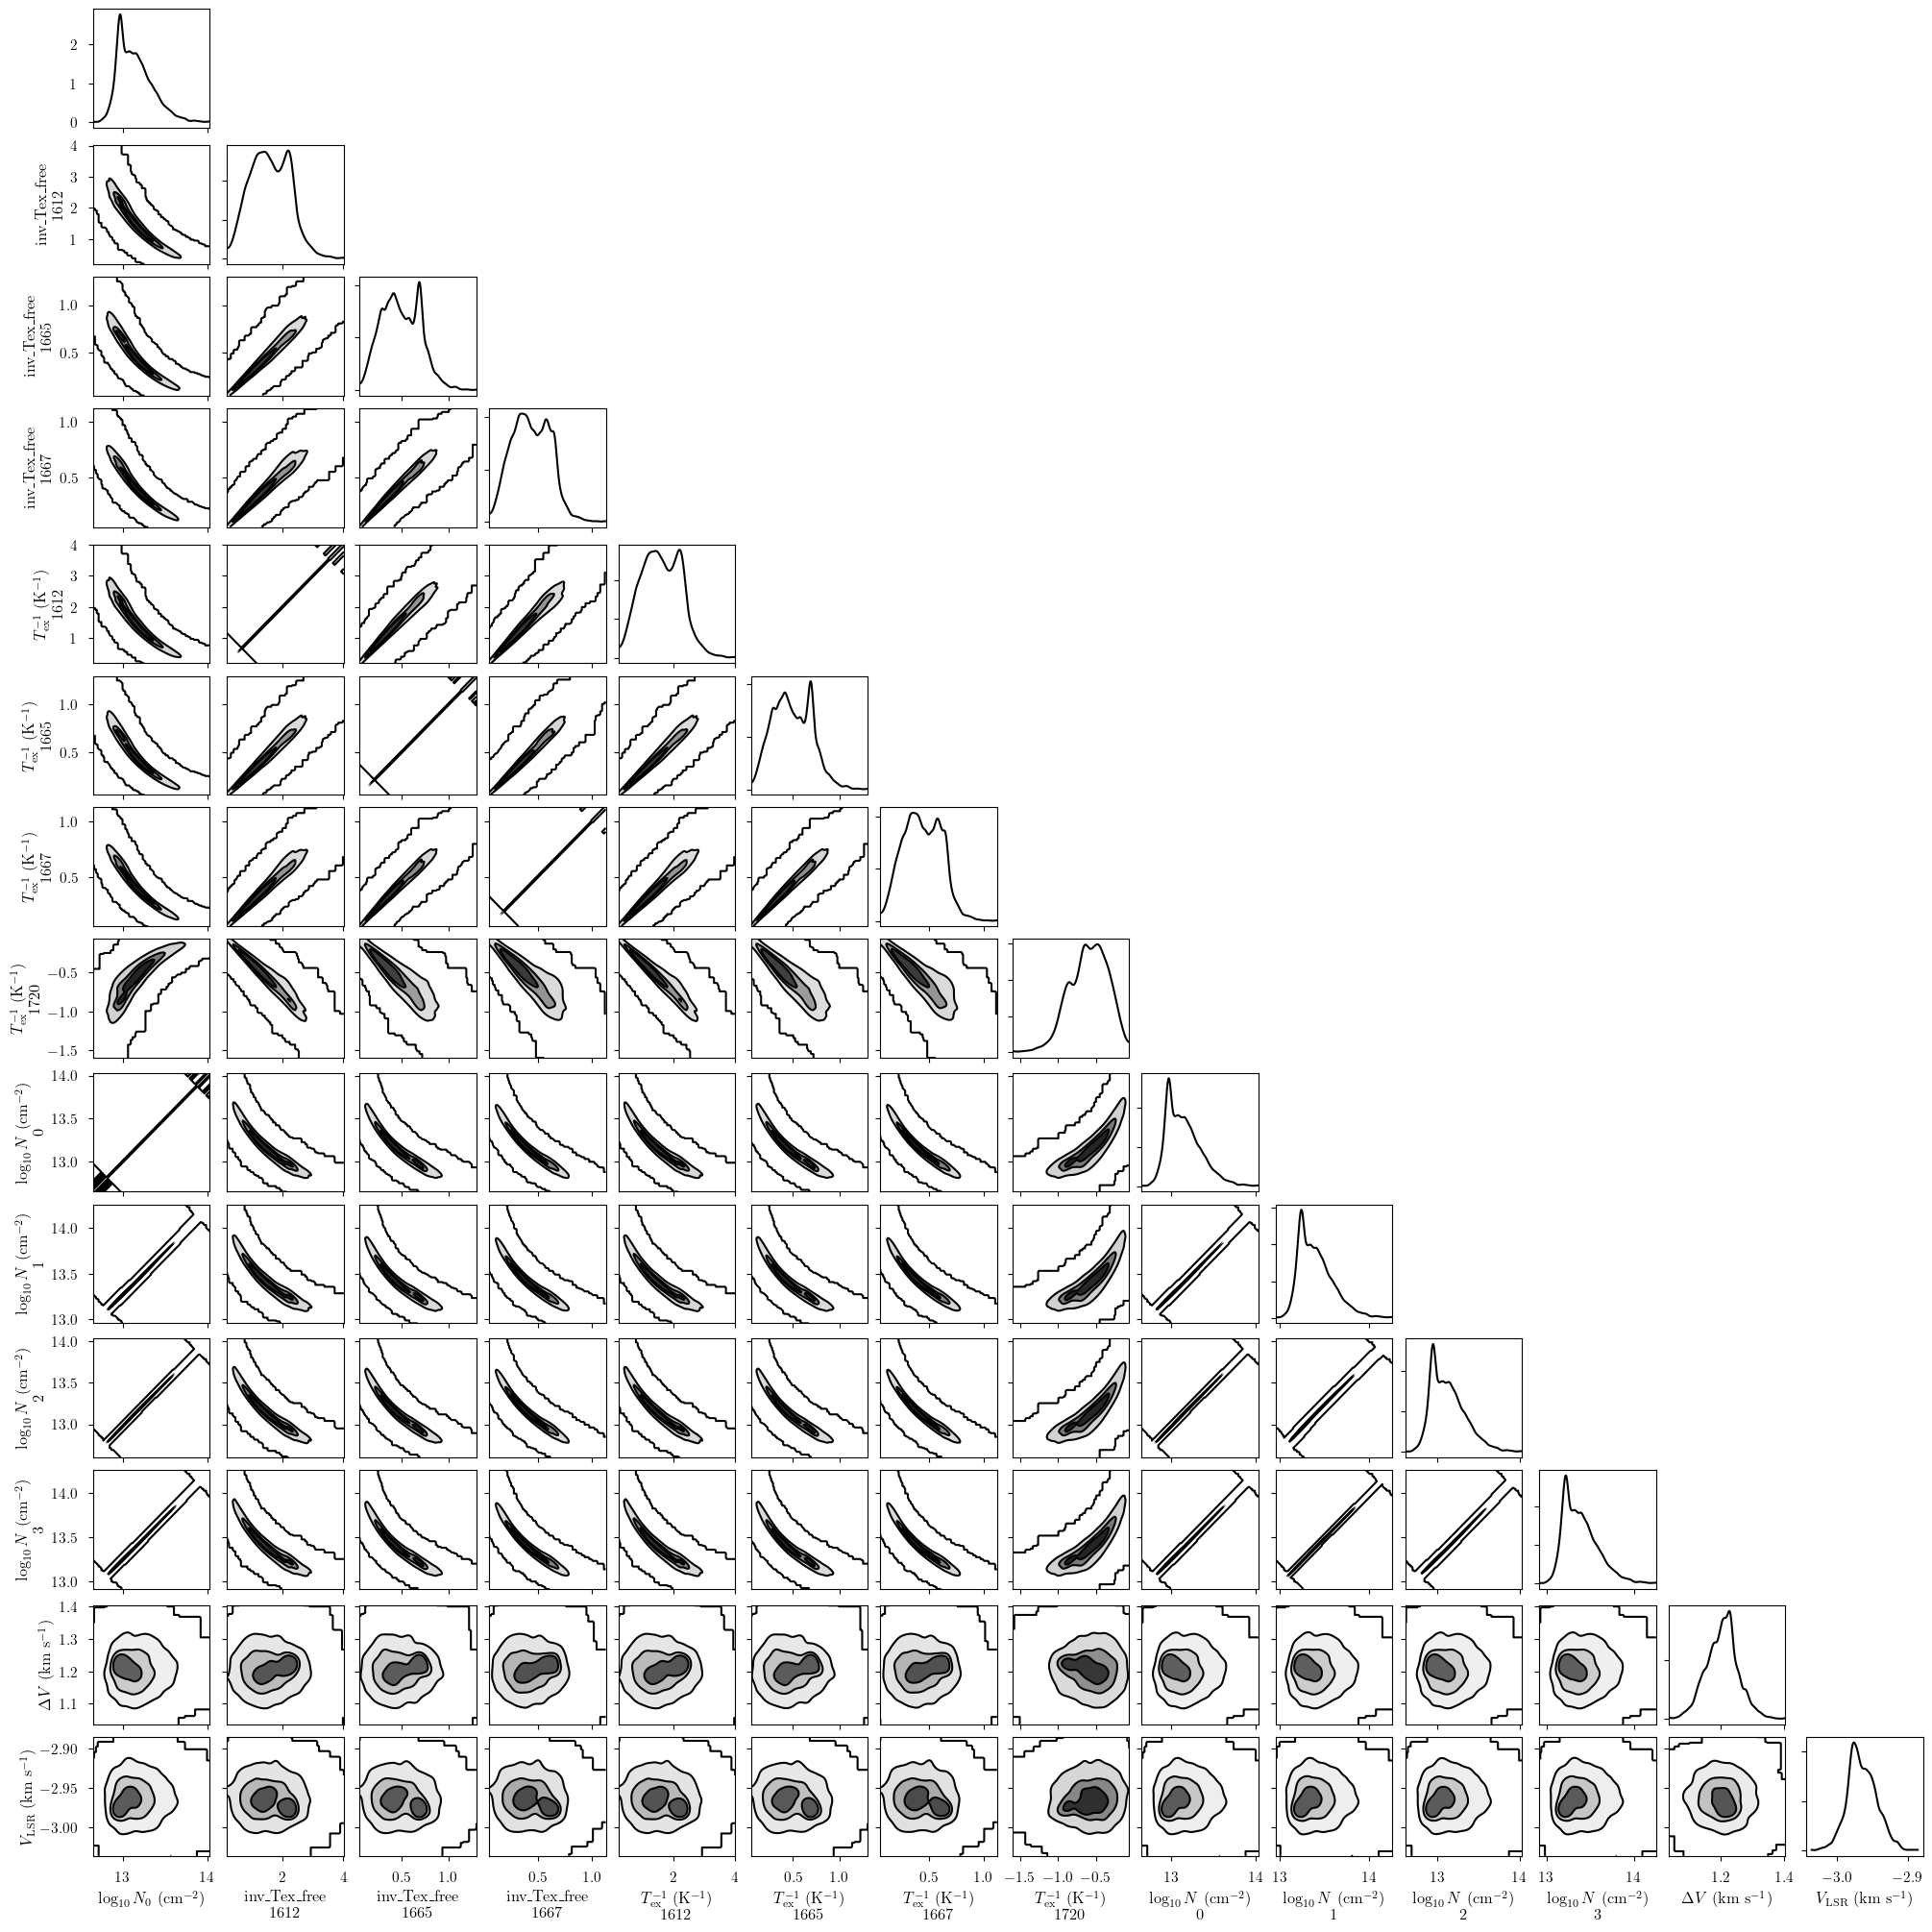

In [19]:
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(20, 20)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [20]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -11061.277484870565


mean     sd  hdi_16%  hdi_84%
baseline_tau_1612_norm[0]    0.076  0.039    0.041    0.115
baseline_tau_1612_norm[1]   -0.619  0.096   -0.714   -0.528
baseline_tau_1612_norm[2]    0.996  0.634    0.383    1.620
baseline_tau_1665_norm[0]   -0.341  0.018   -0.359   -0.324
baseline_tau_1665_norm[1]   -0.287  0.038   -0.329   -0.257
baseline_tau_1665_norm[2]    0.060  0.331   -0.238    0.384
baseline_tau_1667_norm[0]   -0.397  0.023   -0.421   -0.376
baseline_tau_1667_norm[1]   -0.328  0.044   -0.368   -0.284
baseline_tau_1667_norm[2]    1.113  0.414    0.756    1.555
baseline_tau_1720_norm[0]   -0.319  0.025   -0.343   -0.295
baseline_tau_1720_norm[1]   -0.406  0.058   -0.463   -0.347
baseline_tau_1720_norm[2]    1.294  0.447    0.859    1.721
fwhm[0]                      1.204  0.051    1.155    1.252
fwhm[1]                      0.782  0.043    0.722    0.811
fwhm[2]                      1.533  0.019    1.516    1.554
fwhm_norm[0]                 1.204  0.051    1.155    1.252
fwhm_norm[1]                 0.782  0.043    0.722    0.811
fwhm_norm[2]                 1.533  0.019    1.516    1.554
inv_Tex[1612, 0]             1.602  0.630    1.073    2.381
inv_Tex[1612, 1]             0.142  0.279   -0.121    0.337
inv_Tex[1612, 2]            -1.447  0.584   -1.721   -0.633
inv_Tex[1665, 0]             0.493  0.203    0.283    0.703
inv_Tex[1665, 1]             1.298  0.512    0.737    1.737
inv_Tex[1665, 2]             0.654  0.242    0.305    0.776
inv_Tex[1667, 0]             0.439  0.170    0.302    0.662
inv_Tex[1667, 1]             0.824  0.357    0.438    1.110
inv_Tex[1667, 2]             0.479  0.210    0.199    0.567
inv_Tex[1720, 0]            -0.598  0.249   -0.792   -0.280
inv_Tex[1720, 1]             1.922  0.851    0.979    2.539
inv_Tex[1720, 2]             2.453  0.984    1.079    2.906
inv_Tex_free[1612, 0]        1.602  0.630    1.073    2.381
inv_Tex_free[1612, 1]        0.142  0.279   -0.121    0.337
inv_Tex_free[1612, 2]       -1.447  0.584   -1.721   -0.633
inv_Tex_free[1665, 0]        0.493  0.203    0.283    0.703
inv_Tex_free[1665, 1]        1.298  0.512    0.737    1.737
inv_Tex_free[1665, 2]        0.654  0.242    0.305    0.776
inv_Tex_free[1667, 0]        0.439  0.170    0.302    0.662
inv_Tex_free[1667, 1]        0.824  0.357    0.438    1.110
inv_Tex_free[1667, 2]        0.479  0.210    0.199    0.567
inv_Tex_free_norm[1612, 0]   1.602  0.630    1.073    2.381
inv_Tex_free_norm[1612, 1]   0.142  0.279   -0.121    0.337
inv_Tex_free_norm[1612, 2]  -1.447  0.584   -1.721   -0.633
inv_Tex_free_norm[1665, 0]   0.493  0.203    0.283    0.703
inv_Tex_free_norm[1665, 1]   1.298  0.512    0.737    1.737
inv_Tex_free_norm[1665, 2]   0.654  0.242    0.305    0.776
inv_Tex_free_norm[1667, 0]   0.439  0.170    0.302    0.662
inv_Tex_free_norm[1667, 1]   0.824  0.357    0.438    1.110
inv_Tex_free_norm[1667, 2]   0.479  0.210    0.199    0.567
log10_N[0, 0]               13.146  0.205   12.914   13.271
log10_N[0, 1]               12.720  0.184   12.515   12.838
log10_N[0, 2]               13.724  0.166   13.511   13.854
log10_N[1, 0]               13.405  0.192   13.191   13.521
log10_N[1, 1]               12.902  0.200   12.685   13.039
log10_N[1, 2]               13.874  0.193   13.620   14.029
log10_N[2, 0]               13.129  0.212   12.886   13.258
log10_N[2, 1]               12.675  0.201   12.446   12.806
log10_N[2, 2]               13.701  0.174   13.476   13.839
log10_N[3, 0]               13.389  0.197   13.170   13.511
log10_N[3, 1]               12.873  0.211   12.644   13.023
log10_N[3, 2]               13.858  0.201   13.593   14.018
log10_N_0[0]                13.146  0.205   12.914   13.271
log10_N_0[1]                12.720  0.184   12.515   12.838
log10_N_0[2]                13.724  0.166   13.511   13.854
log10_N_0_norm[0]            0.146  0.205   -0.086    0.271
log10_N_0_norm[1]           -0.280  0.184   -0.485   -0.162
log10_N_0_norm[2]            0.724  0.166    0.511    0.854
rms_tau[16

## Visualization using Mean Point Estimate

Here we demonstrate how to visualize the contribution of individual cloud components on the data from the mean posterior point estimates. Inspecting `predict_tau` in the model definition reveals how this works. Note that the mean posterior point estimate might not always be located within the posterior distribution (especially if there are strong parameter correlations)!

In [24]:
# extract parameter mean point estimates
mean_point = model.trace.solution_0.mean(dim=["chain", "draw"])
mean_point

<xarray.Dataset> Size: 832B
Dimensions:                 (baseline_coeff: 3, cloud: 3, component: 4,
                             component_Tex_free: 3, state: 4)
Coordinates:
  * baseline_coeff          (baseline_coeff) int64 24B 0 1 2
  * cloud                   (cloud) int64 24B 0 1 2
  * component               (component) <U4 64B '1612' '1665' '1667' '1720'
  * component_Tex_free      (component_Tex_free) <U4 48B '1612' '1665' '1667'
  * state                   (state) int64 32B 0 1 2 3
Data variables: (12/16)
    baseline_tau_1612_norm  (baseline_coeff) float64 24B 0.07601 -0.6193 0.9955
    baseline_tau_1665_norm  (baseline_coeff) float64 24B -0.3406 -0.2866 0.05989
    baseline_tau_1667_norm  (baseline_coeff) float64 24B -0.3973 -0.3278 1.113
    baseline_tau_1720_norm  (baseline_coeff) float64 24B -0.3188 -0.4064 1.294
    fwhm                    (cloud) float64 24B 1.204 0.7818 1.533
    fwhm_norm               (cloud) float64 24B 1.204 0.7818 1.533
    ...                      ...
    log10_N_0               (cloud) float64 24B 13.15 12.72 13.72
    log10_N_0_norm          (cloud) float64 24B 0.1462 -0.2799 0.7239
    rms_tau                 (component) float64 32B 0.01034 0.00805 ... 0.009934
    rms_tau_norm            (component) float64 32B 0.1034 0.0805 0.1131 0.09934
    velocity                (cloud) float64 24B -2.965 3.018 0.9973
    velocity_norm           (cloud) float64 24B -2.965 3.018 0.9973

In [27]:
from amoeba2 import physics

# evaluate line profile
line_profile = {}
for label in model.model.coords["component"]:
    line_profile[label] = physics.calc_line_profile(
        model.data[f"tau_{label}"].spectral,
        mean_point["velocity"].data,
        mean_point["fwhm"].data,
    ).eval()

# shape: spectral, clouds
print(line_profile["1612"].shape)

(400, 3)


In [29]:
# evaluate optical depth
tau = {}
for i, label in enumerate(model.model.coords["component"]):
    if label in ["1612", "1665"]:
        N_u = 10.0 ** mean_point["log10_N"].data[2]
    else:
        N_u = 10.0 ** mean_point["log10_N"].data[3]
    tau[label] = physics.calc_optical_depth(
        N_u,
        mean_point["inv_Tex"].data[i],
        line_profile[label],
        model.mol_data["freq"][i],
        model.mol_data["Aul"][i],
    ).eval()
    
# shape: spectral, clouds
print(tau["1612"].shape)

(400, 3)


In [51]:
# evaluate un-normalized baseline
baseline = {}
for i, label in enumerate(model.model.coords["component"]):
    baseline_norm = np.sum([
        mean_point[f"baseline_tau_{label}_norm"].data[j] / (j + 1.0)**j * model.data[f"tau_{label}"].spectral_norm**j
        for j in range(model.baseline_degree + 1)
    ], axis=0)
    baseline[label] = model.data[f"tau_{label}"].unnormalize_brightness(baseline_norm)
    
# shape: spectral
print(baseline['1612'].shape)

(400,)


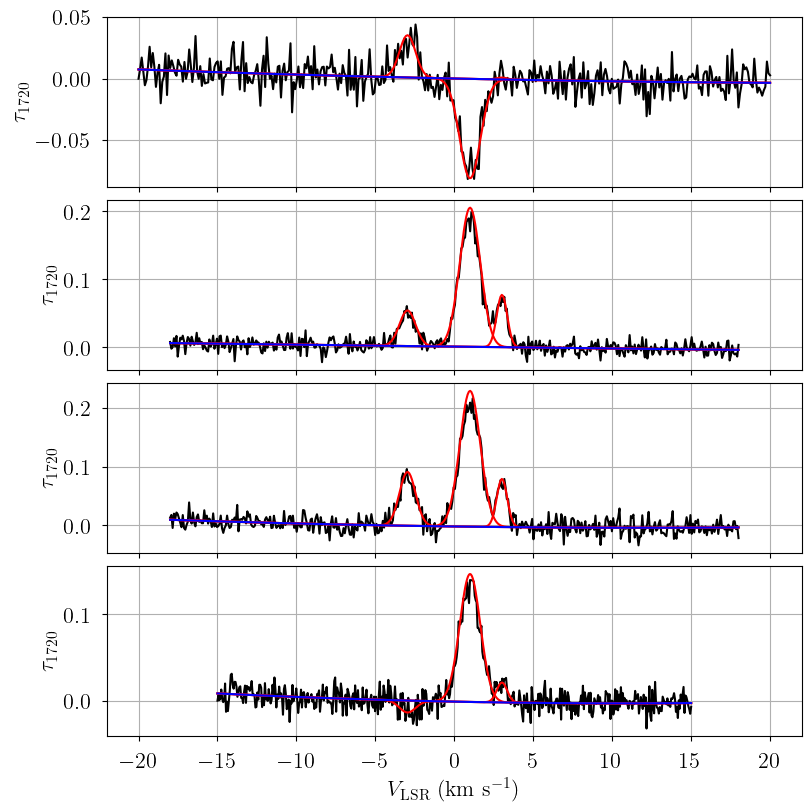

In [52]:
# Plot cloud contributions over data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for i, label in enumerate(model.model.coords["component"]):
    axes[i].plot(model.data[f"tau_{label}"].spectral, model.data[f"tau_{label}"].brightness, "k-")
    for j in range(n_clouds):
        axes[i].plot(model.data[f"tau_{label}"].spectral, tau[label][:, j] + baseline[label], 'r-')
    # baseline
    axes[i].plot(model.data[f"tau_{label}"].spectral, baseline[label], 'b-')
    axes[i].set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)